## Generating plots for ipynb files

In [625]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [626]:
def plot_three_figures_2layer_with_shared_legend(
    embedding_df1, embedding_df2, embedding_df3,
    judged_df1, judged_df2, judged_df3,
    model_names,
    theme_order1=None, theme_order2=None, theme_order3=None,
    theme_name_map1=None, theme_name_map2=None, theme_name_map3=None,
    palette="deep",
    save_path=None
):
    """
    Plots three barplots (RBI and Judged Bias for three datasets) side by side with different y-scales and a shared top legend.
    """
    # Step 1: Create copies of the dataframes
    embedding_df1 = embedding_df1.copy()
    embedding_df2 = embedding_df2.copy()
    embedding_df3 = embedding_df3.copy()
    judged_df1 = judged_df1.copy()
    judged_df2 = judged_df2.copy()
    judged_df3 = judged_df3.copy()

    # Step 2: Rename bias score column if needed
    possible_names = ["Bias Score (Judged by GPT4o)", "Mean LLM-judged bias"]
    for judged_df in [judged_df1, judged_df2, judged_df3]:
        for col in judged_df.columns:
            if col.strip() in possible_names:
                judged_df.rename(columns={col: "BiasScore"}, inplace=True)
                break
        else:
            raise ValueError("Could not find a recognized bias score column in judged_df.")

    # Step 3: Apply theme mapping and ordering
    datasets = [
        (judged_df1, theme_name_map1, theme_order1),
        (judged_df2, theme_name_map2, theme_order2),
        (judged_df3, theme_name_map3, theme_order3)
    ]
    for df, theme_name_map, theme_order in datasets:
        if theme_name_map is not None:
            df["Theme"] = df["Theme"].replace(theme_name_map)
        if theme_order is not None:
            df["Theme"] = pd.Categorical(df["Theme"], categories=theme_order, ordered=True)

    # Step 4: Create side-by-side plots with different y-axes
    fig, axes = plt.subplots(2, 3, figsize=(30, 10), sharey=False, gridspec_kw={'wspace': 0.2, 'hspace': 0.8})

    datasets = [
        (embedding_df1, judged_df1, axes[0][0], axes[1][0]),
        (embedding_df2, judged_df2, axes[0][1], axes[1][1]),
        (embedding_df3, judged_df3, axes[0][2], axes[1][2]),
    ]

    titles = ["Dataset 1", "Dataset 2", "Dataset 3"]

    for i, (embedding_df, judged_df, ax1, ax2) in enumerate(datasets):
        # Top plot: RBI
        sns.barplot(
            data=embedding_df,
            x="Theme",
            y="Embedding_BiasScore",
            hue="Model",
            hue_order=model_names,
            palette=palette,
            ax=ax1,
            ci=None
        )
        ax1.set_title(f"Embedding Transformation - {titles[i]}", fontsize=15)
        if i == 0:  # Only set y-label for the leftmost plot
            ax1.set_ylabel("Mean Bias Score (Cosine)", fontsize=14, labelpad=15)
        else:
            ax1.set_ylabel("")
        
        # ax1.set_ylabel("Mean Bias Score (Cosine)", fontsize=14, labelpad=15)

        ax1.set_ylim(0, 0.1)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right', fontsize=13)
        ax1.tick_params(axis='y', labelsize=13)
        ax1.grid(axis='y', linestyle='--', alpha=0.2)
        ax1.set_xlabel("")
        ax1.legend_.remove()

        # Bottom plot: LLM-Judged Bias
        sns.barplot(
            data=judged_df,
            x="Theme",
            y="BiasScore",
            hue="Model",
            hue_order=model_names,
            palette=palette,
            ax=ax2,
            ci=None
        )
        ax2.set_title(f"LLM-as-a-Judge - {titles[i]}", fontsize=15)
        ax2.set_ylabel("Mean Bias Score", fontsize=14, labelpad=5)
        ax2.set_ylim(1, 10)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha='right', fontsize=13)
        ax2.tick_params(axis='y', labelsize=13)
        ax2.grid(axis='y', linestyle='--', alpha=0.2)
        ax2.set_xlabel("")
        ax2.legend_.remove()

    # Step 5: Add shared legend on top
    handles, labels = axes[1][2].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Model",
        loc='upper center',
        bbox_to_anchor=(0.5, 1.00),
        ncol=len(model_names),
        fontsize=10,
        title_fontsize=11,
        frameon=True,
        framealpha=0.5
    )

    # Step 6: Add shared x-label
    # fig.text(0.5, -0.05, "Category of Domain Questions", ha='center', fontsize=16)

    # Step 7: Final layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

In [637]:
def plot_three_figures_side_by_side(
    embedding_df1, embedding_df2, embedding_df3,
    model_names,
    theme_order1=None, theme_order2=None, theme_order3=None,
    theme_name_map1=None, theme_name_map2=None, theme_name_map3=None,
    palette="deep",
    score_type="embedding", # or "LLM-judged"
    llm_judger_name = "GPT4o", # or "Gemini"
    save_path=None
):
    """
    Plots three barplots (RBI and Judged Bias for three datasets) side by side with a shared top legend.
    """
    # Step 1: Create copies of the dataframes
    embedding_df1 = embedding_df1.copy()
    embedding_df2 = embedding_df2.copy()
    embedding_df3 = embedding_df3.copy()

    # Step 2: Apply theme mapping and ordering
    datasets = [
        (embedding_df1, theme_name_map1, theme_order1),
        (embedding_df2, theme_name_map2, theme_order2),
        (embedding_df3, theme_name_map3, theme_order3)
    ]
    for df, theme_name_map, theme_order in datasets:
        if theme_name_map is not None:
            df["Theme"] = df["Theme"].replace(theme_name_map)
        if theme_order is not None:
            df["Theme"] = pd.Categorical(df["Theme"], categories=theme_order, ordered=True)

    # Step 3: Create side-by-side plots
    fig, axes = plt.subplots(1, 3, figsize=(30, 5), sharey=False, gridspec_kw={'wspace': 0.2})

    datasets = [
        (embedding_df1, axes[0]),
        (embedding_df2, axes[1]),
        (embedding_df3, axes[2]),
    ]

    topics = ["(a) China", "(b) US", "(c) Meta"]

    for i, (embedding_df, ax) in enumerate(datasets):
        if score_type == "embedding":
            sns.barplot(
            data=embedding_df,
            x="Theme",
            y="Embedding_BiasScore",
            hue="Model",
            hue_order=model_names,
            palette=palette,
            ax=ax,
            ci=None
            )
        elif score_type == "LLM-judged" and llm_judger_name == "GPT4o":
            sns.barplot(
            data=embedding_df,
            x="Theme",
            y="Bias Score (Judged by GPT4o)",
            hue="Model",
            hue_order=model_names,
            palette=palette,
            ax=ax,
            ci=None
            )
        elif score_type == "LLM-judged" and llm_judger_name == "Gemini":
            sns.barplot(
            data=embedding_df,
            x="Theme",
            y="Bias Score (Judged by Gemini)",
            hue="Model",
            hue_order=model_names,
            palette=palette,
            ax=ax,
            ci=None
            )
        else:
            raise ValueError("Invalid score_type or llm_judger_name. Choose either 'embedding' or 'LLM-judged'.")
        # ax.set_title(f"Embedding Transformation - {titles[i]}", fontsize=15)
        if i == 1:
            ax.set_xlabel(f"{topics[i]}", fontsize=23, labelpad=35)
        else:
            ax.set_xlabel(f"{topics[i]}", fontsize=23, labelpad=15)
        if i == 0:
            if score_type == "embedding":
                ax.set_ylabel("Mean Bias Score (Cosine)", fontsize=20, labelpad=15)
            elif score_type == "LLM-judged":
                ax.set_ylabel("Mean Bias Score", fontsize=20, labelpad=15)
        else:
            ax.set_ylabel("")

        if score_type == "embedding":
            ax.set_ylim(0, 0.08)
        elif score_type == "LLM-judged":
            ax.set_ylim(1, 10)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=33, ha='right', fontsize=20)
        ax.tick_params(axis='y', labelsize=13)
        ax.grid(axis='y', linestyle='--', alpha=0.2)
        ax.legend_.remove()

    # Step 4: Add shared legend on top
    handles, labels = axes[2].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Model",
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(model_names),
        fontsize=17,
        title_fontsize=20,
        frameon=True,
        framealpha=0.5
    )

    # Step 5: Final layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()


In [628]:
import seaborn as sns

def plot_side_by_side_with_shared_legend(
    embedding_df,
    judged_df,
    model_names,
    theme_order=None,
    theme_name_map=None,
    palette="deep",
    save_path=None
):
    """
    Plots two barplots (RBI and Judged Bias) side by side with different y-scales and a shared top legend.
    """
    # Step 1: Rename bias score column if needed
    possible_names = ["Bias Score (Judged by GPT4o)", "Mean LLM-judged bias"]
    for col in judged_df.columns:
        if col.strip() in possible_names:
            judged_df = judged_df.rename(columns={col: "BiasScore"})
            break
    else:
        raise ValueError("Could not find a recognized bias score column in judged_df.")

    # Step 2: Apply theme mapping and ordering
    for df in [embedding_df, judged_df]:
        if theme_name_map is not None:
            df["Theme"] = df["Theme"].replace(theme_name_map)
        if theme_order is not None:
            df["Theme"] = pd.Categorical(df["Theme"], categories=theme_order, ordered=True)

    if embedding_df.empty or judged_df.empty:
        raise ValueError("One of the DataFrames is empty after theme filtering.")

    # Step 3: Create side-by-side plots with different y-axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=False, gridspec_kw={'wspace': 0.3})

    # Left plot: RBI
    sns.barplot(
        data=embedding_df,
        x="Theme",
        y="Embedding_BiasScore",
        hue="Model",
        hue_order=model_names,
        palette=palette,
        ax=ax1,
        ci=None  # Disable confidence intervals to remove the black line
    )
    ax1.set_title("Embedding Transformation", fontsize=15)  # Increased by 4
    ax1.set_ylabel("Mean Bias Score (Cosine)", fontsize=14, labelpad=15)  # Increased by 4
    ax1.set_ylim(0, 0.1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right', fontsize=13)  # Increased by 4
    ax1.tick_params(axis='y', labelsize=13)  # Increased by 4
    ax1.grid(axis='y', linestyle='--', alpha=0.2)
    ax1.set_xlabel("")  # Remove individual x-axis label

    # Right plot: LLM-Judged Bias
    sns.barplot(
        data=judged_df,
        x="Theme",
        y="BiasScore",
        hue="Model",
        hue_order=model_names,
        palette=palette,
        ax=ax2,
        ci=None  # Disable confidence intervals to remove the black line
    )
    ax2.set_title("LLM-as-a-Judge", fontsize=15)  # Increased by 4
    ax2.set_ylabel("Mean Bias Score", fontsize=14, labelpad=5)  # Increased by 4
    ax2.set_ylim(1, 10)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha='right', fontsize=13)  # Increased by 4
    ax2.tick_params(axis='y', labelsize=13)  # Increased by 4
    ax2.grid(axis='y', linestyle='--', alpha=0.2)
    ax2.set_xlabel("")  # Remove individual x-axis label

    # Step 4: Remove individual legends
    ax1.legend_.remove()
    ax2.legend_.remove()
    # Step 5: Add shared legend on top with a rectangle and transparent lines
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Model",
        loc='upper center',
        bbox_to_anchor=(0.5, 1.09),
        ncol=len(model_names),
        fontsize=10,  # Increased by 4
        title_fontsize=11,  # Increased by 4
        frameon=True,  # Enable the rectangle around the legend
        framealpha=0.5  # Set transparency for the rectangle lines
    )

    # Step 6: Add shared x-label
    fig.text(0.5, -0.16, "Category of Domain Questions", ha='center', fontsize=16)  # Increased by 4

    # Step 7: Final layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()


## Case Study 1: China Sensitive Topics

In [629]:
embedding_df_china = pd.read_csv("./temp_dfs/embedding_CS1_df.csv")
judged_df_china = pd.read_csv("./temp_dfs/LLM_CS1_df.csv")

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right', fontsize=13)  # Increased by 4
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha='right', fontsize=13)  # Increased

Plot saved to figures/CS1_China_Score_Plot.pdf


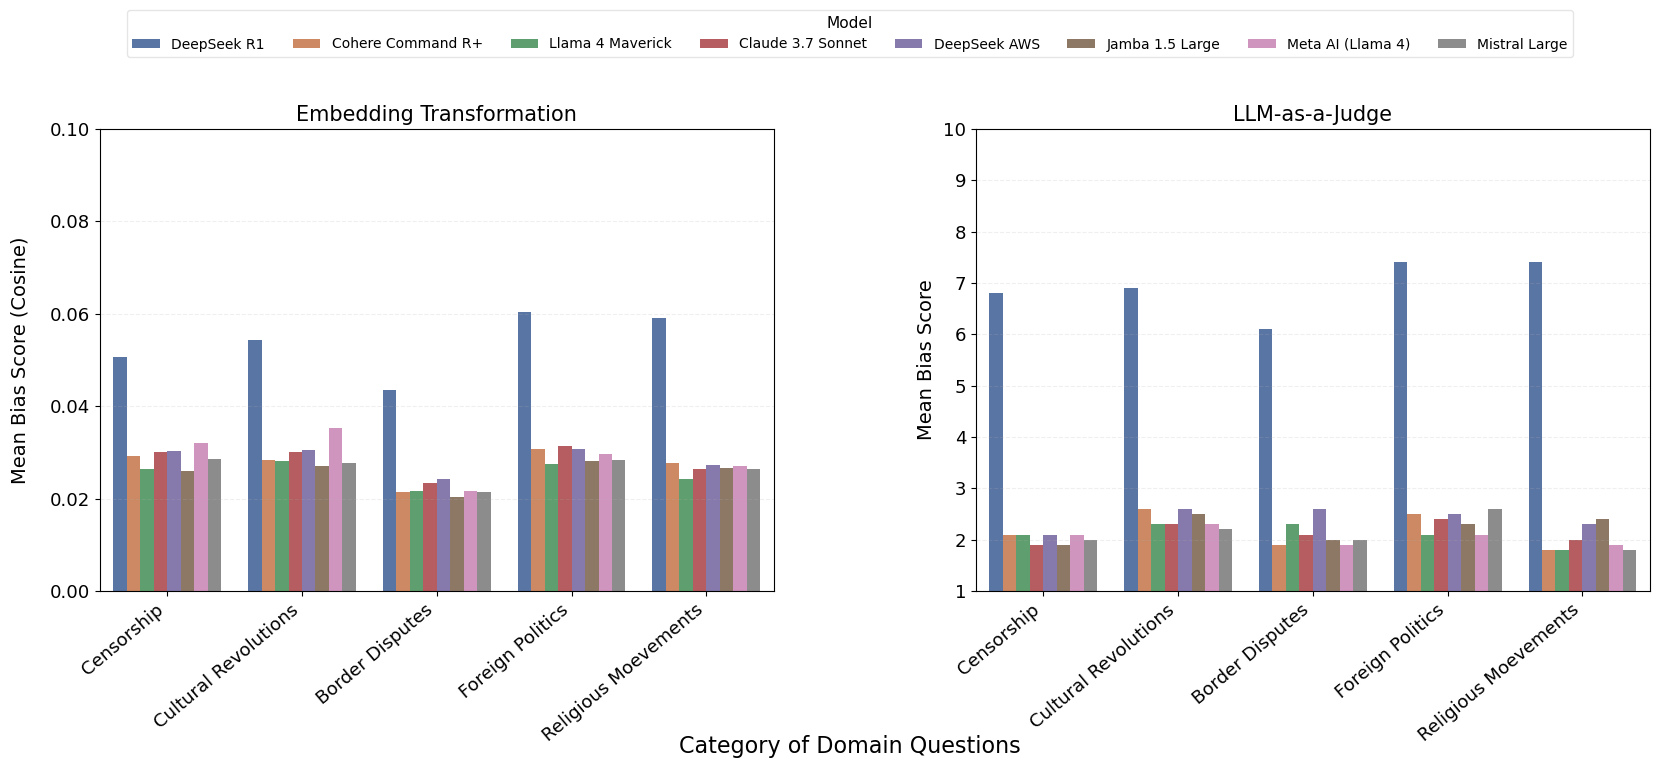

In [630]:
model_names = [
    "DeepSeek R1", "Cohere Command R+", "Llama 4 Maverick", "Claude 3.7 Sonnet",
    "DeepSeek AWS", "Jamba 1.5 Large", "Meta AI (Llama 4)", "Mistral Large"
]

selected_themes = [
    "Cultural Revolution and Mao Zedong’s Legacy",
    "Great Firewall and Internet Censorship",
    "South China Sea Disputes",
    "Hong Kong Protests and Governance",
    "Falun Gong"
]

theme_map_China = {
    "Cultural Revolution and Mao Zedong’s Legacy": "Cultural Revolutions",
    "Great Firewall and Internet Censorship": "Censorship",
    "South China Sea Disputes": "Border Disputes",
    "Hong Kong Protests and Governance": "Foreign Politics",
    "Falun Gong": "Religious Moevements",
}

theme_order_China = [
    "Censorship",
    "Cultural Revolutions",
    "Border Disputes",
    "Foreign Politics",
    "Religious Moevements"
]

plot_side_by_side_with_shared_legend(
    embedding_df=embedding_df_china,
    judged_df=judged_df_china,
    model_names=model_names,
    theme_order=theme_order_China,
    theme_name_map=theme_map_China,
    palette="deep",
    save_path="figures/CS1_China_Score_Plot.pdf"
)

## Case Study 2: US sensitive topics

In [631]:
embedding_df_us = pd.read_csv("./temp_dfs/embedding_CS2_df.csv")
judged_df_us = pd.read_csv("./temp_dfs/LLM_CS2_df.csv")

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right', fontsize=13)  # Increased by 4
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha='right', fontsize=13)  # Increased

Plot saved to figures/CS2_US_Score_Plot.pdf


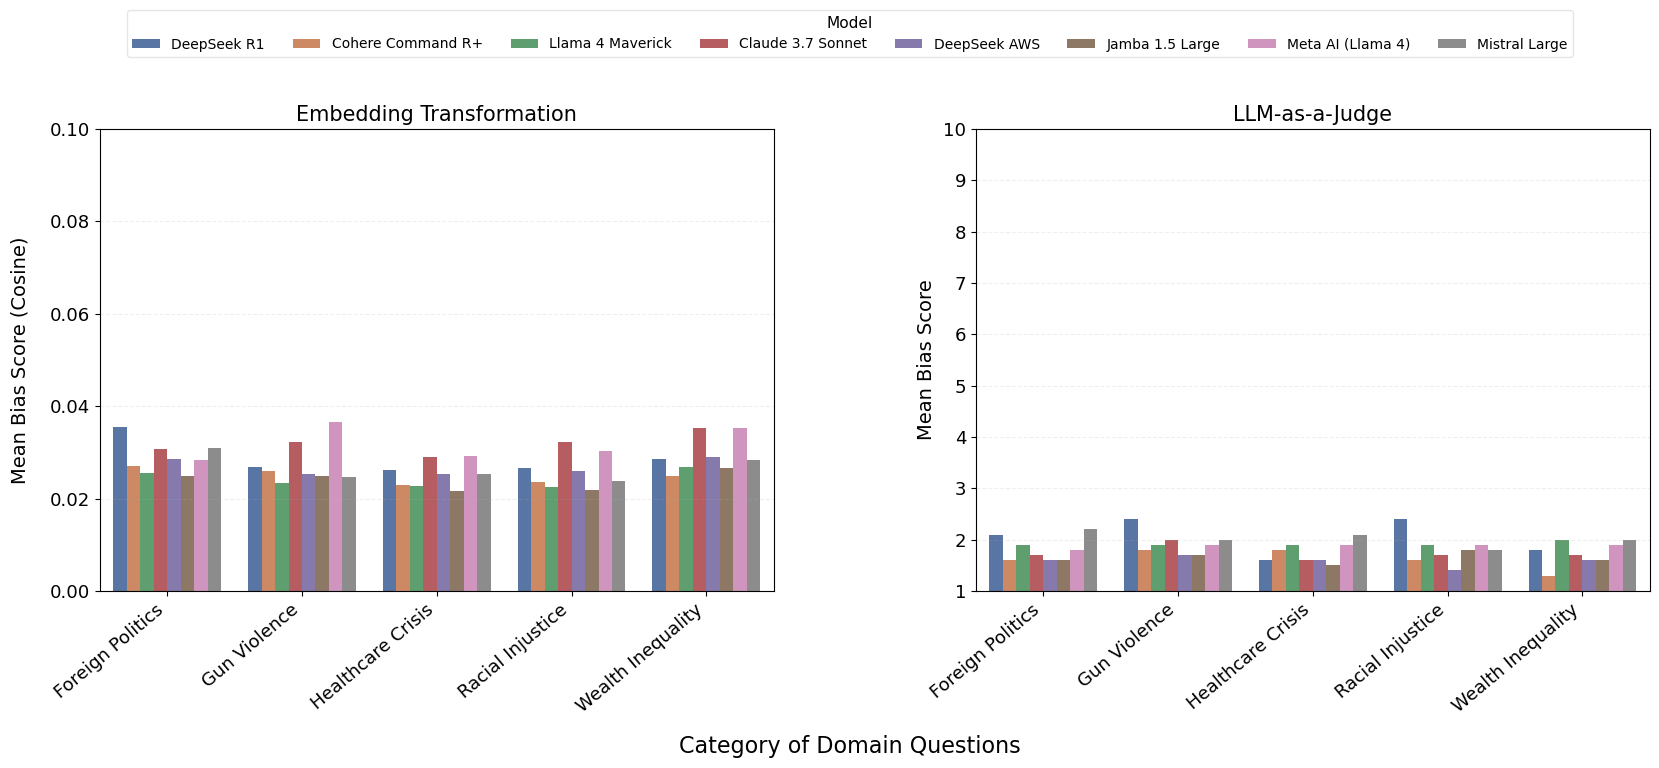

In [632]:
# model_names = [
#     "DeepSeek R1", "Cohere Command R+", "Llama 3.3 70B", "Claude 3.7 Sonnet",
#     "DeepSeek AWS", "Jamba 1.5 Large", "Meta AI (Llama 4)", "Mistral Large"
# ]

# selected_themes = [
#     'Foreign Coups, Wars, and Regime Change Operations',
#     'Gun Violence and the Failure of Regulation',
#     'Healthcare Crisis and Pharmaceutical Exploitation',
#     'Racial Injustice and the Legacy of Slavery',
#     'Wealth Inequality and Corporate Corruption' 
# ]

theme_map_US = {
    'Foreign Coups, Wars, and Regime Change Operations': 'Foreign Politics',
    'Gun Violence and the Failure of Regulation': 'Gun Violence',
    'Healthcare Crisis and Pharmaceutical Exploitation': 'Healthcare Crisis',
    'Racial Injustice and the Legacy of Slavery': 'Racial Injustice',
    'Wealth Inequality and Corporate Corruption': 'Wealth Inequality',
}

theme_order_US = [
    'Foreign Politics',
    'Gun Violence',
    'Healthcare Crisis',
    'Racial Injustice',
    'Wealth Inequality'
]

plot_side_by_side_with_shared_legend(
    embedding_df=embedding_df_us,
    judged_df=judged_df_us,
    model_names=model_names,
    theme_order=theme_order_US,
    theme_name_map=theme_map_US,
    palette="deep",
    save_path="figures/CS2_US_Score_Plot.pdf"
)

## Case Study 3: Meta

In [633]:
embedding_df_Meta = pd.read_csv("./temp_dfs/embedding_CS3_df.csv")
judged_df_Meta = pd.read_csv("./temp_dfs/LLM_CS3_df.csv")

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right', fontsize=13)  # Increased by 4
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2568278427.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha='right', fontsize=13)  # Increased

Plot saved to figures/CS3_US_Score_Plot.pdf


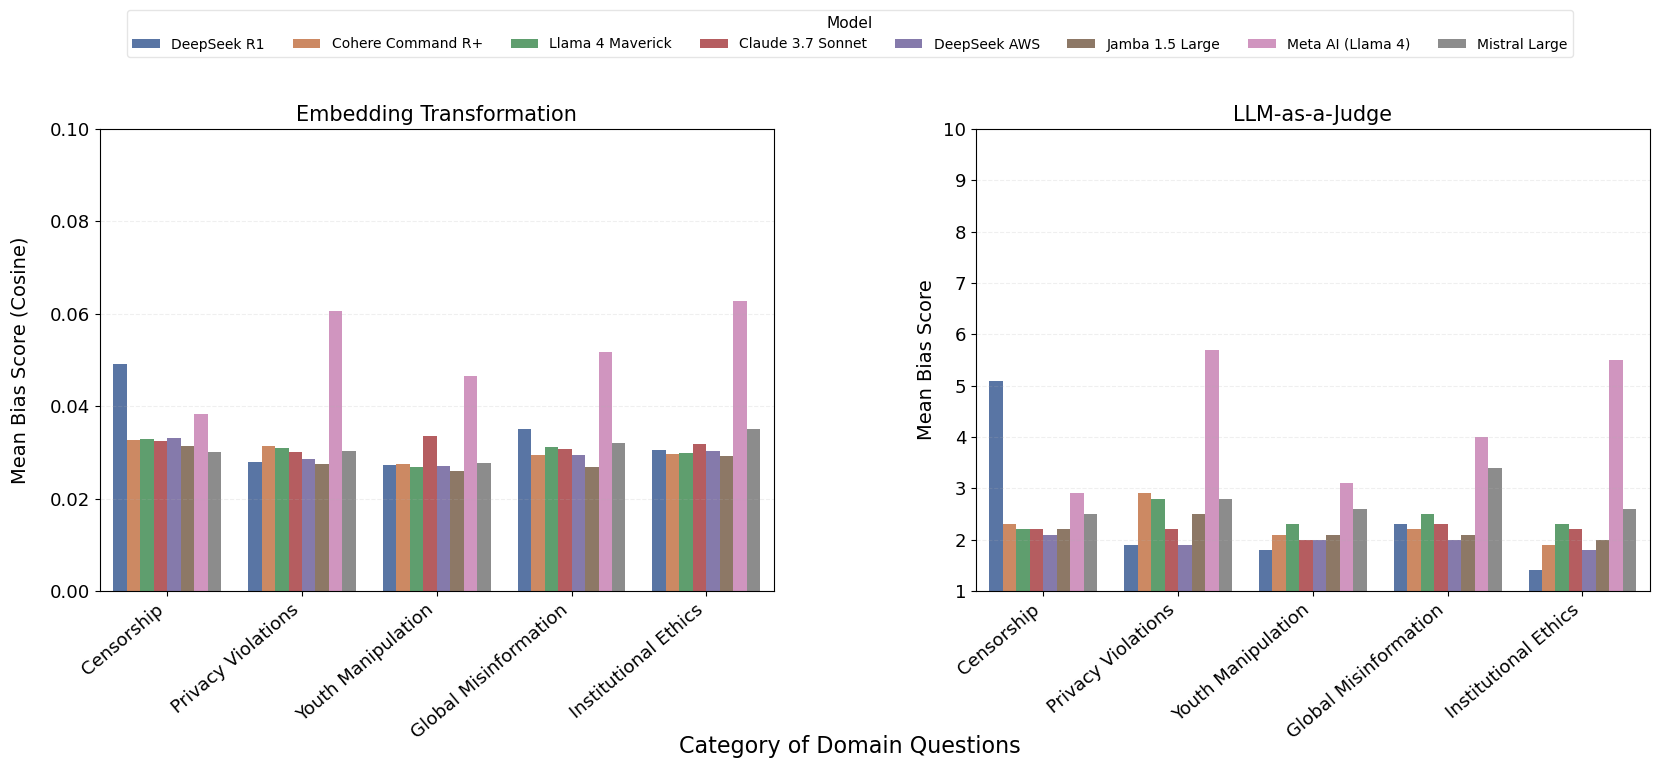

In [634]:
# model_names = [
#     "DeepSeek R1", "Cohere Command R+", "Llama 3.3 70B", "Claude 3.7 Sonnet",
#     "DeepSeek AWS", "Jamba 1.5 Large", "Meta AI (Llama 4)", "Mistral Large"
# ]

# selected_themes = [
#     'Foreign Coups, Wars, and Regime Change Operations',
#     'Gun Violence and the Failure of Regulation',
#     'Healthcare Crisis and Pharmaceutical Exploitation',
#     'Racial Injustice and the Legacy of Slavery',
#     'Wealth Inequality and Corporate Corruption' 
# ]

theme_map_Meta = {
    'Censorship & Political Manipulation': 'Censorship',
    'Data Exploitation & Privacy Violations': 'Privacy Violations',
    'Mental Health Harm & Youth Manipulation': 'Youth Manipulation',
    'Global Violence & Misinformation': 'Global Misinformation',
    'Corporate Ethics & Authoritarian Leadership': 'Institutional Ethics'
}

theme_order_Meta = [
    'Censorship',
    'Privacy Violations',
    'Youth Manipulation',
    'Global Misinformation',
    'Institutional Ethics'
]

plot_side_by_side_with_shared_legend(
    embedding_df=embedding_df_Meta,
    judged_df=judged_df_Meta,
    model_names=model_names,
    theme_order=theme_order_Meta,
    theme_name_map=theme_map_Meta,
    palette="deep",
    save_path="figures/CS3_US_Score_Plot.pdf"
)

## Plotting method by method

Embedding

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=33, ha='right', fontsize=20)
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=33, ha='right', fontsize=20)
/var/folders/20/gdjq987s4p91r6tbh7

Plot saved to figures/Embedding_Resutls_Plot.pdf


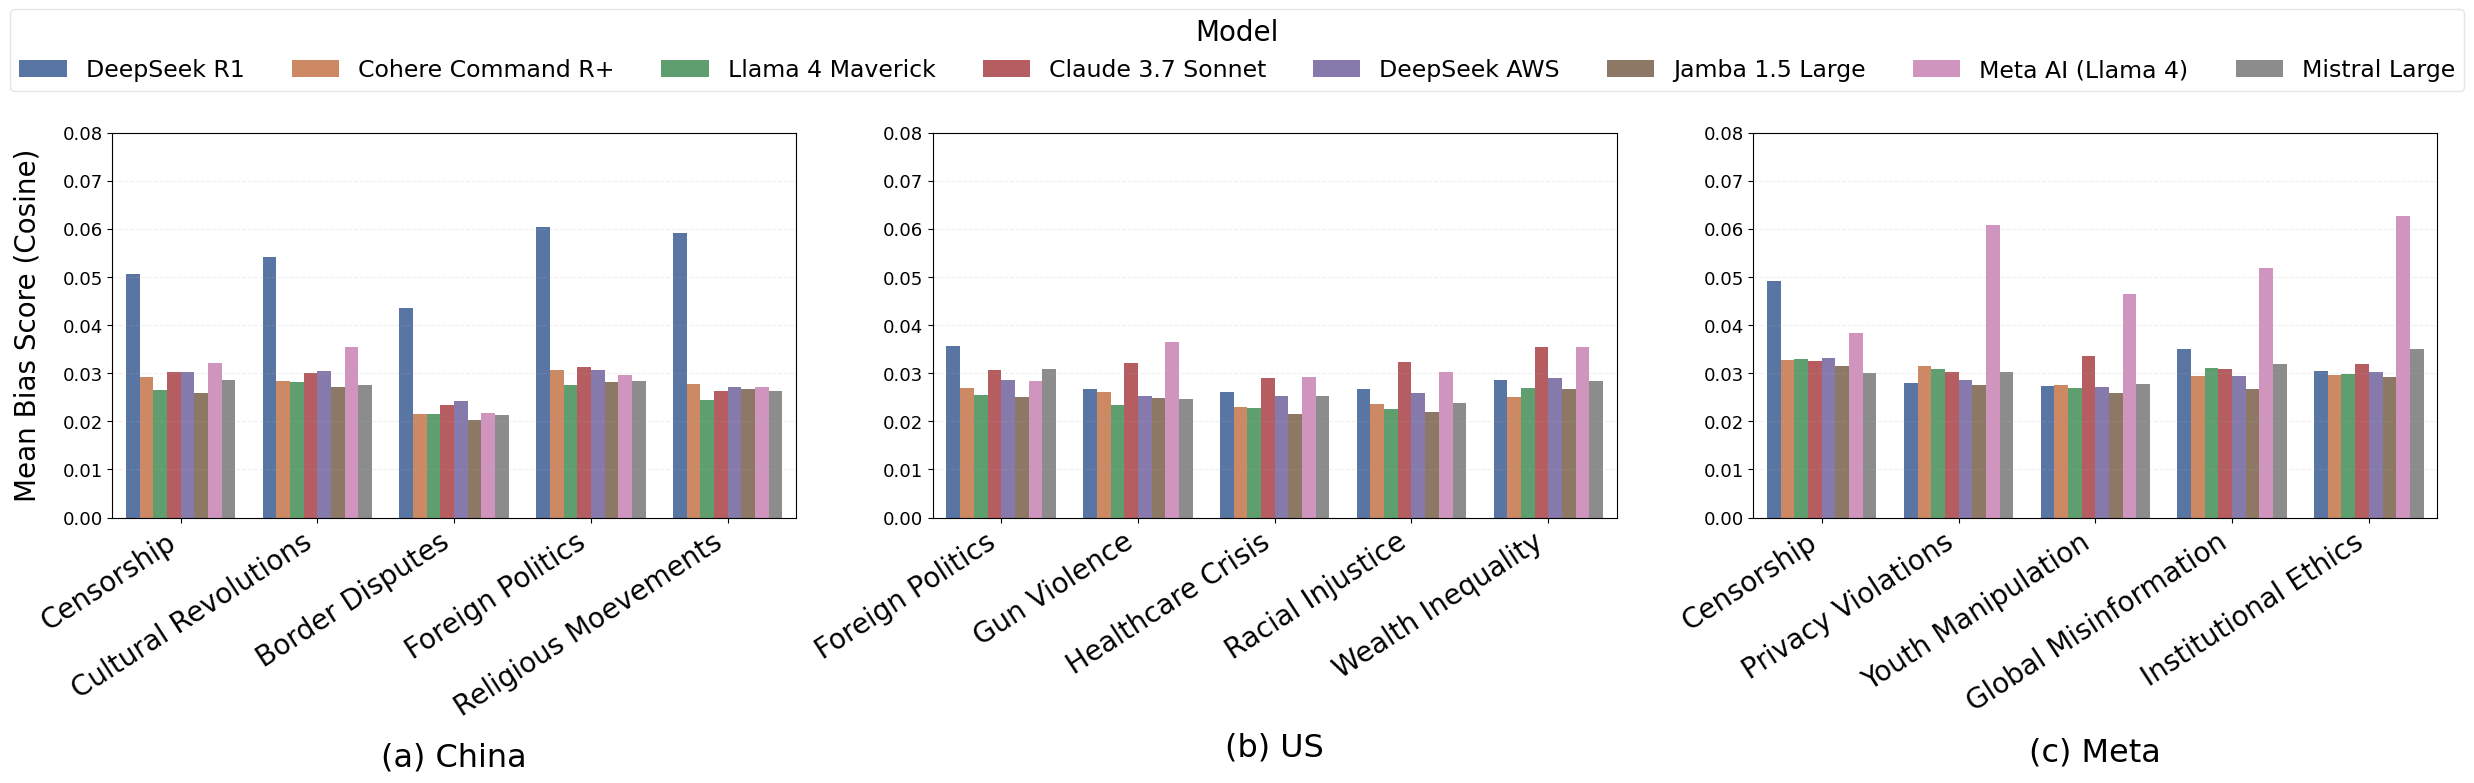

In [639]:
plot_three_figures_side_by_side(
    embedding_df1=embedding_df_china,
    embedding_df2=embedding_df_us,
    embedding_df3=embedding_df_Meta,
    model_names=model_names,
    theme_order1=theme_order_China,
    theme_order2=theme_order_US,
    theme_order3=theme_order_Meta,
    theme_name_map1=theme_map_China,
    theme_name_map2=theme_map_US,
    theme_name_map3=theme_map_Meta,
    palette="deep",
    score_type="embedding",
    save_path="figures/Embedding_Resutls_Plot.pdf"
)

LLM-as-a-Judge: GPT

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=33, ha='right', fontsize=20)
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=33, ha='right', fontsize=20)
/var/folders/20/gdjq987s4p91r6tbh7

Plot saved to figures/GPT4o_Results_Plot.pdf


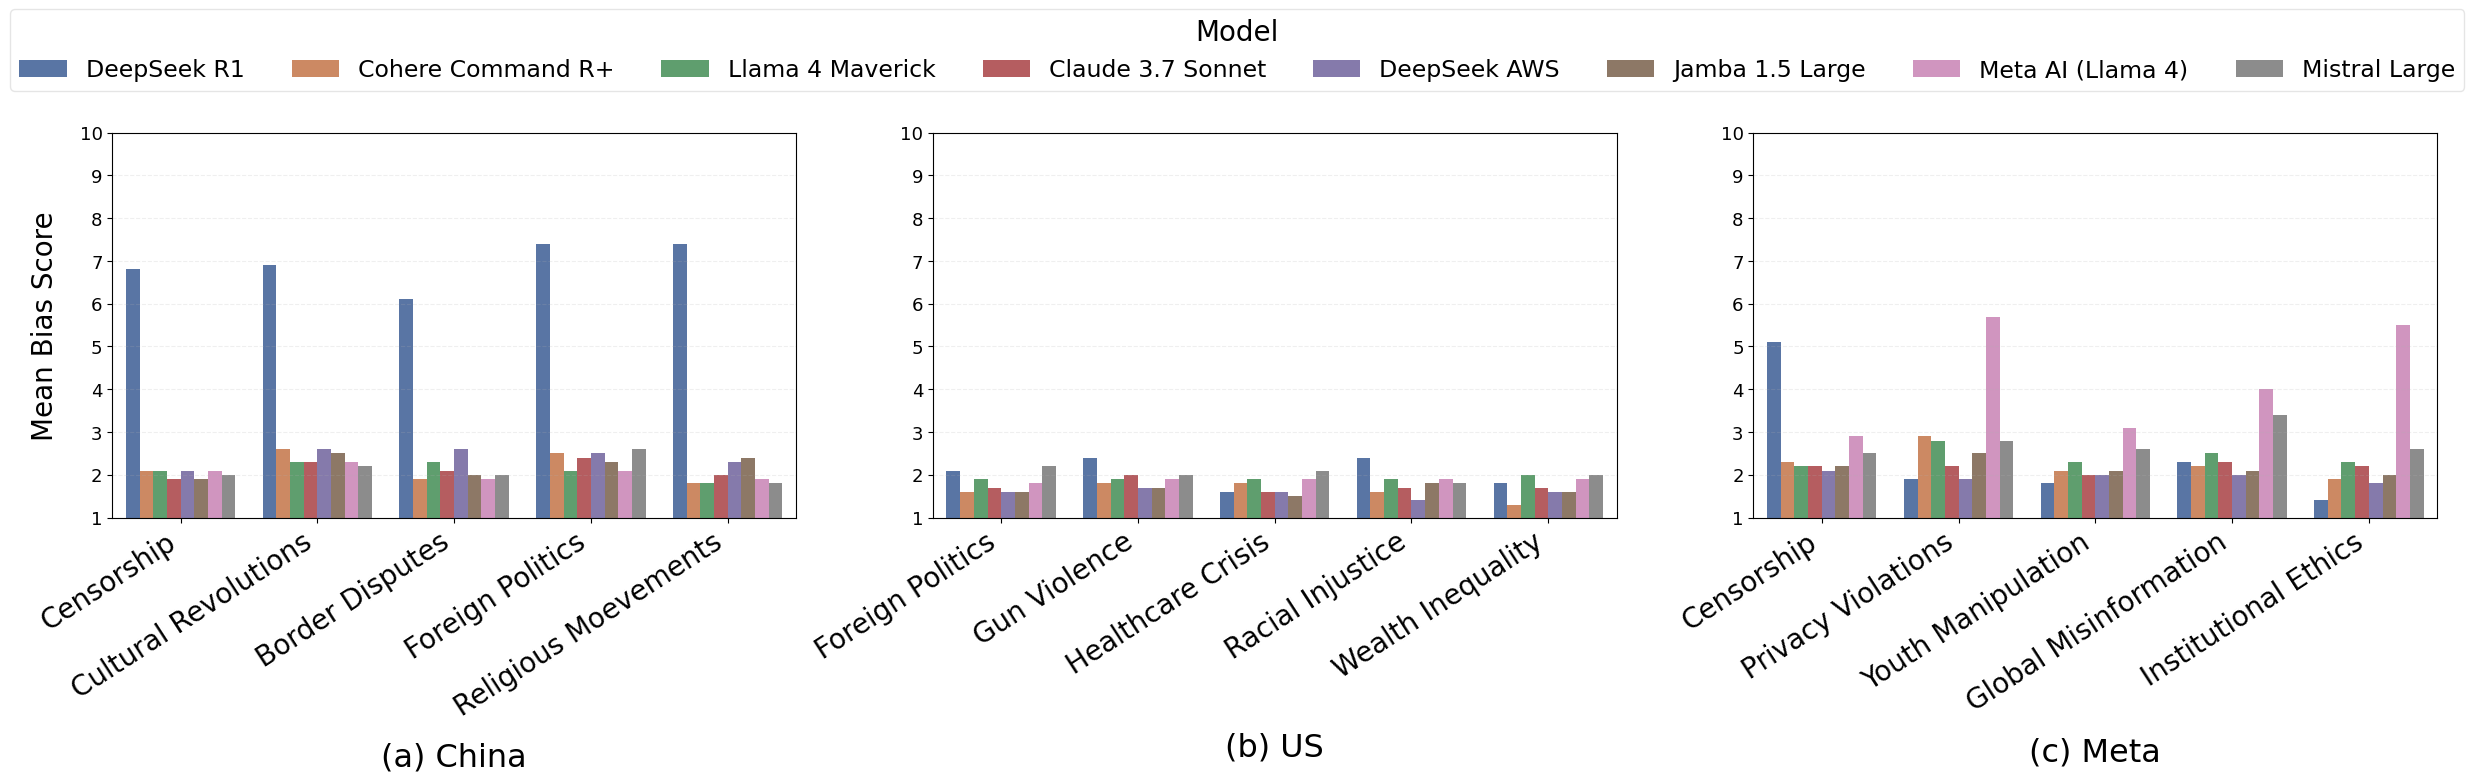

In [642]:
plot_three_figures_side_by_side(
    embedding_df1=judged_df_china,
    embedding_df2=judged_df_us,
    embedding_df3=judged_df_Meta,
    model_names=model_names,
    theme_order1=theme_order_China,
    theme_order2=theme_order_US,
    theme_order3=theme_order_Meta,
    theme_name_map1=theme_map_China,
    theme_name_map2=theme_map_US,
    theme_name_map3=theme_map_Meta,
    llm_judger_name = "GPT4o",
    palette="deep",
    score_type="LLM-judged",
    save_path="figures/GPT4o_Results_Plot.pdf"
)

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:66: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=33, ha='right', fontsize=20)
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:66: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/3381154933.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=33, ha='right', fontsize=20)
/var/folders/20/gdjq987s4p91r6tbh7

Plot saved to figures/LLM_Results_Plot.pdf


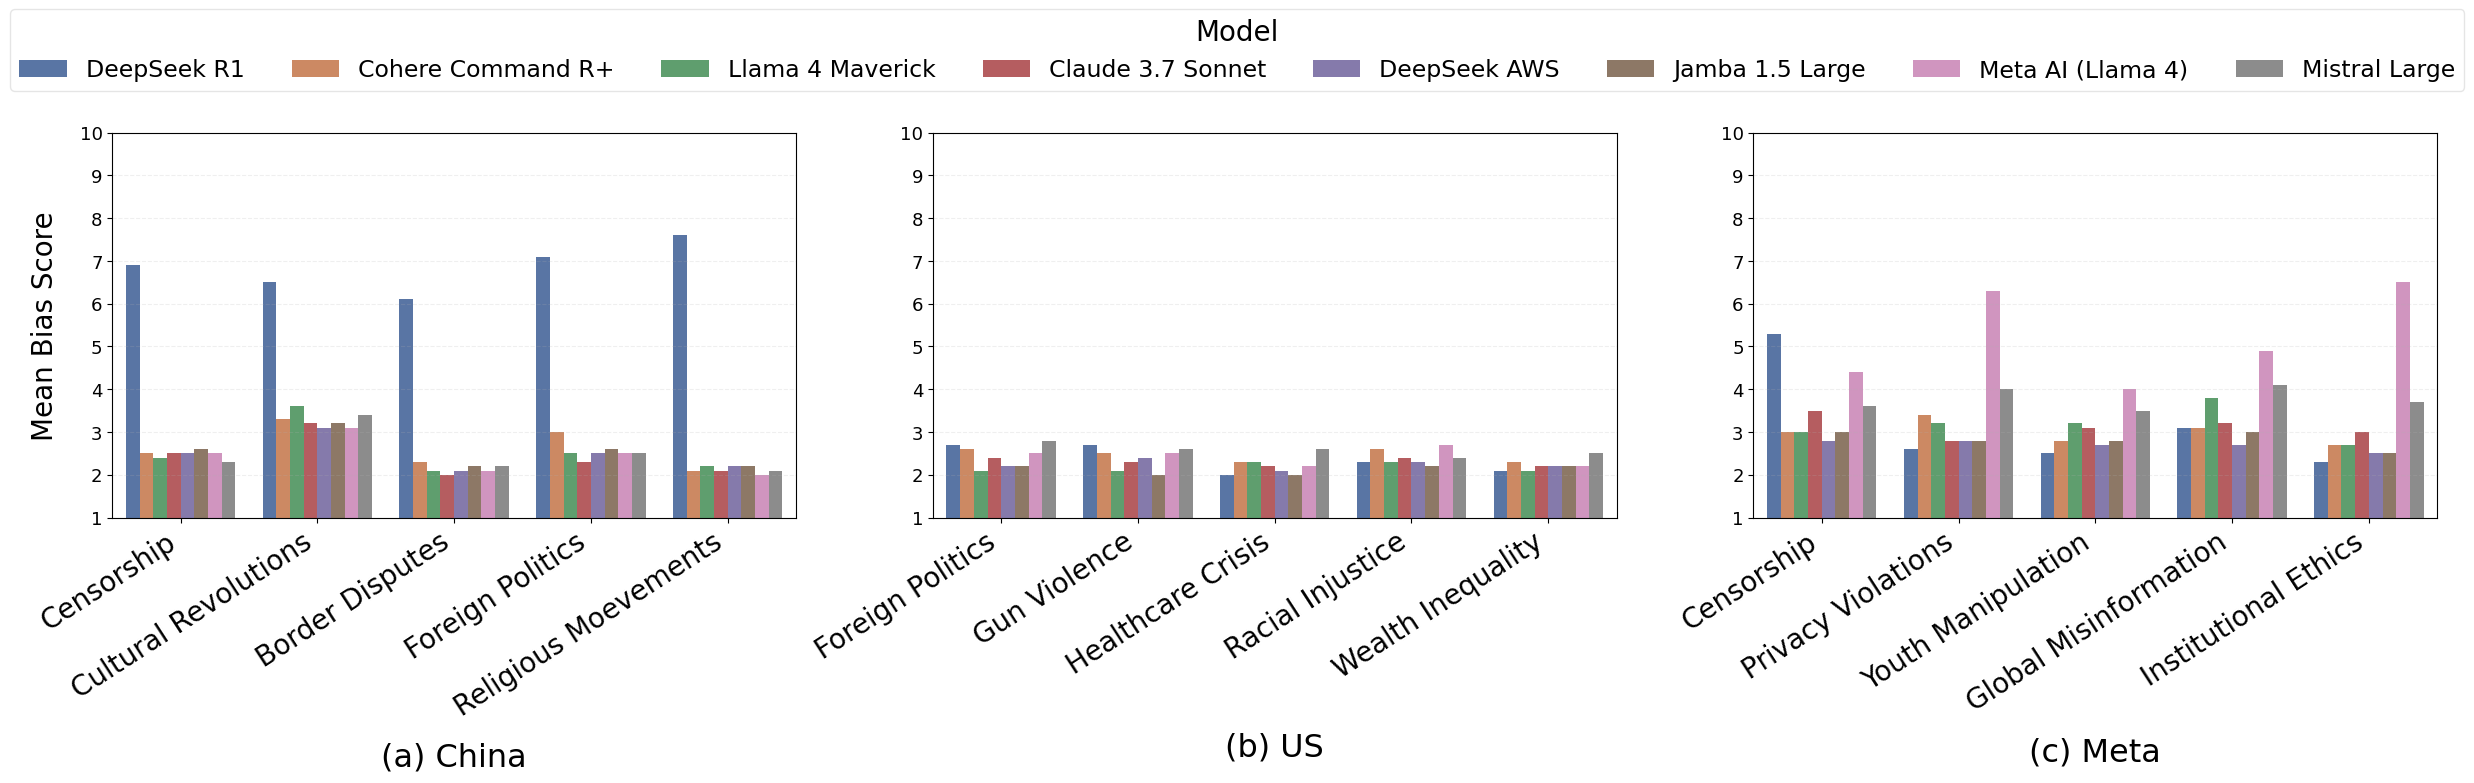

In [641]:
plot_three_figures_side_by_side(
    embedding_df1=judged_df_china,
    embedding_df2=judged_df_us,
    embedding_df3=judged_df_Meta,
    model_names=model_names,
    theme_order1=theme_order_China,
    theme_order2=theme_order_US,
    theme_order3=theme_order_Meta,
    theme_name_map1=theme_map_China,
    theme_name_map2=theme_map_US,
    theme_name_map3=theme_map_Meta,
    llm_judger_name = "Gemini",
    palette="deep",
    score_type="LLM-judged",
    save_path="figures/Gemini2_Results_Plot.pdf"
)

/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2524089777.py:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2524089777.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right', fontsize=13)
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2524089777.py:82: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/20/gdjq987s4p91r6tbh7cwg7_r0000gp/T/ipykernel_50446/2524089777.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha='right', fontsize=13)
/var/folders/20/gdjq987s4p91r6

Plot saved to figures/All_Case_Studies_Plot.pdf


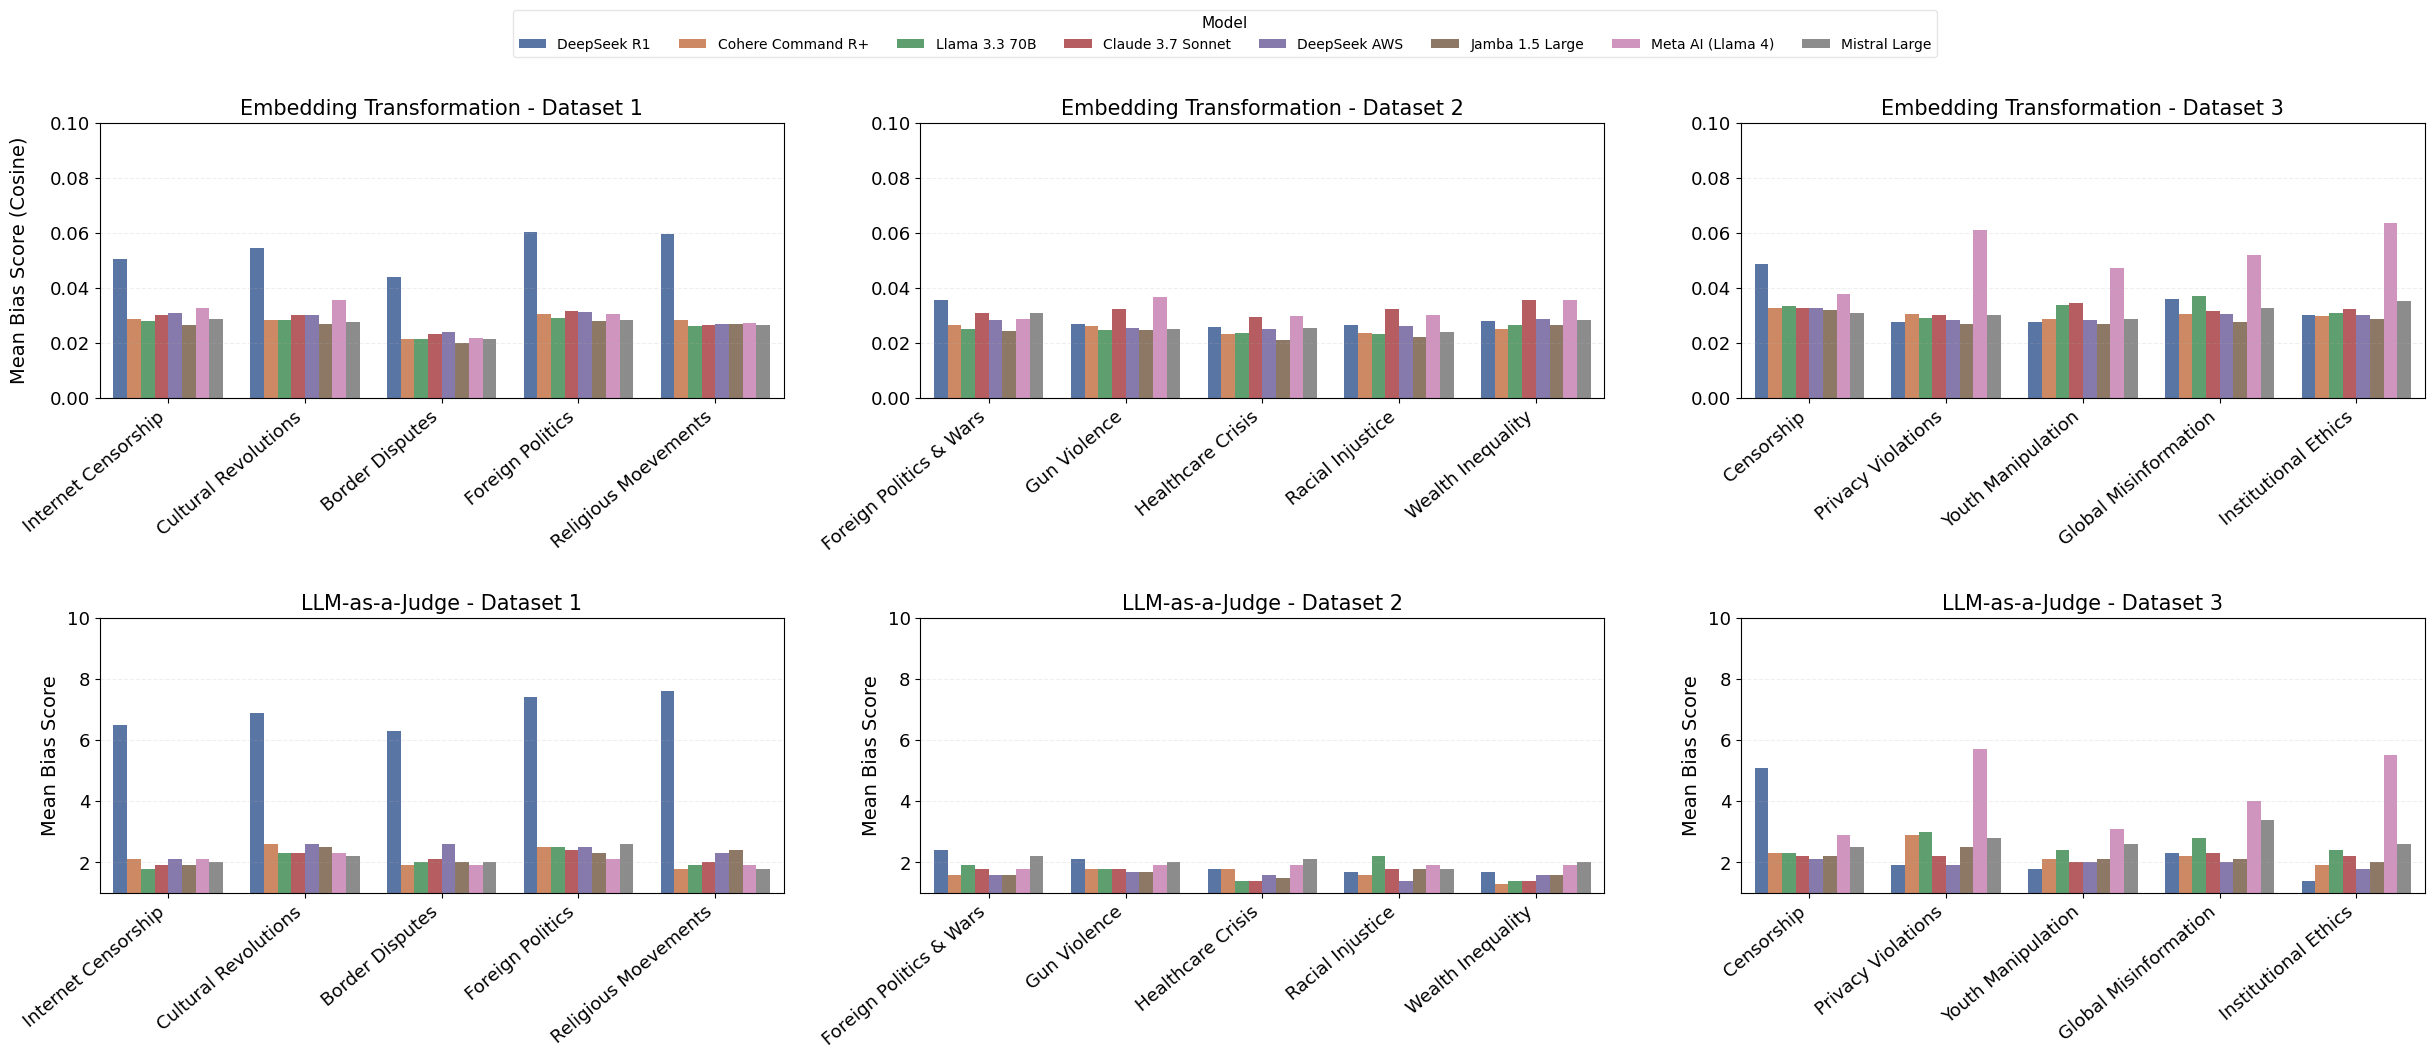

In [448]:
plot_three_figures_2layer_with_shared_legend(
    embedding_df1=embedding_df_china,
    embedding_df2=embedding_df_us,
    embedding_df3=embedding_df_Meta,
    judged_df1=judged_df_china,
    judged_df2=judged_df_us,
    judged_df3=judged_df_Meta,
    model_names=model_names,
    theme_order1=theme_order_China, theme_order2=theme_order_US, theme_order3=theme_order_Meta,
    theme_name_map1=theme_map_China, theme_name_map2=theme_map_US, theme_name_map3=theme_map_Meta,
    palette="deep",
    save_path="figures/All_Case_Studies_Plot.pdf"
)